<a href="https://colab.research.google.com/github/dsskonuru/satellite-constellation-optimization-ga-qa/blob/master/Satellite_Constellation_Optimization_(GA%2BQA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install dimod
!pip install networkx 
!pip install dwave-neal

Suppose you have a set of ``N`` satellites and ``k`` targets on Earth that you
want to observe. Each of your satellites has varying capabilities for Earth
observation; in particular, the amount of ground that they can observe for a
set amount of time is different. Since there are ``k`` targets, you would like
to have ``k`` constellations to monitor said targets. 

Note: We are assuming that ``N`` is a multiple of ``k``.

In [0]:
N = 35
k = 10 # number of targets

subconstellation_size = N // k  # satellites per constellation

Each of the 12 satellites (labelled 0-11) has a coverage score. This could be calculated as the percentage of time  that the Earth region is in range of the satellite. We are assuming a random value in this case, this can be replaced by real values in a particular application.

In [25]:
import numpy as np
import matplotlib.pyplot as plt

coverage = {}
for i in range(N):
  coverage[i] = np.random.randint(0, 100)/100
print(coverage)

score_threshold = 0.4

{0: 0.92, 1: 0.4, 2: 0.28, 3: 0.06, 4: 0.21, 5: 0.36, 6: 0.66, 7: 0.77, 8: 0.32, 9: 0.93, 10: 0.51, 11: 0.77, 12: 0.47, 13: 0.36, 14: 0.61, 15: 0.64, 16: 0.12, 17: 0.3, 18: 0.72, 19: 0.96, 20: 0.79, 21: 0.92, 22: 0.6, 23: 0.48, 24: 0.36, 25: 0.84, 26: 0.51, 27: 0.71, 28: 0.95, 29: 0.78, 30: 0.01, 31: 0.62, 32: 0.77, 33: 0.95, 34: 0.69}


The ``score_threshold`` is used to determine bad constellations. Constellations with coverage less than this value is not considered. It is assigned an arbitrarily picked number i.e `0.4`. 

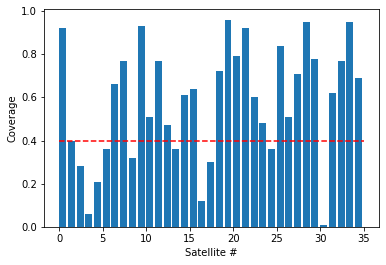

In [26]:
lists = sorted(coverage.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.xlabel("Satellite #")
plt.ylabel("Coverage")
plt.hlines(score_threshold, 0, N, linestyles='dashed', colors='r')
plt.bar(x, y, align='edge')
plt.show()

In [27]:
import itertools

subconstellations = {} # create dict of subconstellations and its coverage

for subconstellation in itertools.combinations(range(N), N//k):
    score = sum(coverage[v] for v in subconstellation) / subconstellation_size

    if score < score_threshold:
        continue

    subconstellations[frozenset(subconstellation)] = score

# print(subconstellations)    
print(len(subconstellations))

5736


### Genetic Algorithm

In [0]:
def init_pop(sol_per_pop):
  population = []
  for i in range(sol_per_pop):
    constellation = [np.random.choice(list(subconstellations.keys())) for j in range(k)]
    population.append(constellation)
  return population

In [0]:
import itertools

def cal_fitness(population):
  fitness = []

  for con in population:
    coverage = sum([subconstellations[subcon] for subcon in con])

    # penalty multiple subcons sharing the same satellite
    for a, b in itertools.combinations(con, 2): 
      if not a.isdisjoint(b):
        coverage-=1

    fitness.append(coverage)
      
  return fitness

In [0]:
def select_mating_pool(population, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = []
    for parent_num in range(num_parents):
        max_fitness_idx = fitness.index(max(fitness))
        parents.append(population[max_fitness_idx])
        fitness[max_fitness_idx] = -999
    return parents

In [0]:
def crossover(parents, offspring_size):
    offsprings = []
    # The point at which crossover takes place between two parents. Usually it is at the center.
    crossover_point = np.random.randint(k)

    for i in range(offspring_size):
        # Index of the first parent to mate.
        parent1_idx = i%len(parents)
        # Index of the second parent to mate.
        parent2_idx = (i+1)%len(parents)
        offspring = parents[parent1_idx][:crossover_point]+parents[parent2_idx][crossover_point:]
        offsprings.append(offspring)

    return offsprings

In [0]:
def mutation(offspring_crossover):
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(len(offspring_crossover)):
        # The random value to be added to the gene.
        random_idx = np.random.randint(N*k)
        random_value = np.random.choice(list(subconstellations.keys()))
        offspring_crossover[idx] = offspring_crossover[idx][:random_idx] + [random_value] + offspring_crossover[idx][random_idx+1:]
    return offspring_crossover

In [0]:
sol_per_pop = 50
num_generations = 2000

fitness_g = []
new_population = init_pop(sol_per_pop)
num_parents_mating = sol_per_pop // 2

for generation in range(num_generations):
    
    # Measuring the fitness of each chromosome in the population.
    fitness = cal_fitness(new_population)

    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(new_population, fitness, num_parents_mating)

    # Generating next generation using crossover.
    offspring_crossover = crossover(parents, offspring_size=sol_per_pop-len(parents))

    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover)

    # Creating the new population based on the parents and offspring.
    new_population = parents + offspring_mutation

    fitness_g.append(max(fitness))

# Getting the best solution after iterating finishing all generations.
fitness = cal_fitness(new_population)
best_match_idx = np.where(fitness == np.max(fitness))[0][0]


In [34]:
print('Fitness :', max(fitness))
print('Constellation :', new_population[best_match_idx])

Fitness : 5.983333333333333
Constellation : [frozenset({0, 5, 31}), frozenset({32, 30, 7}), frozenset({1, 3, 20}), frozenset({16, 12, 21}), frozenset({33, 19, 14}), frozenset({9, 10, 18}), frozenset({17, 27, 13}), frozenset({26, 34, 29}), frozenset({2, 23, 15}), frozenset({26, 34, 6}), frozenset({24, 25, 11}), frozenset({8, 4, 28})]


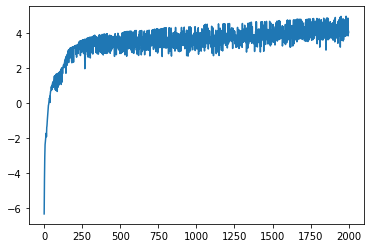

In [35]:
import matplotlib.pyplot as plt

plt.plot(fitness_g)

### Quantum Annealing

In [36]:
s = set()
for con in new_population:
    for subcon in con:    
      s.add(subcon)

subcons = {i:subconstellations[i] for i in list(s)}
# print(subcons)
# print(len(subcons))

{frozenset({8, 32, 7}): 0.62, frozenset({32, 30, 7}): 0.5166666666666667, frozenset({25, 11, 4}): 0.6066666666666666, frozenset({25, 18, 19}): 0.84, frozenset({26, 34, 29}): 0.66, frozenset({26, 34, 6}): 0.62, frozenset({8, 4, 28}): 0.49333333333333335, frozenset({33, 26, 30}): 0.49, frozenset({27, 3, 15}): 0.47, frozenset({32, 6, 22}): 0.6766666666666667, frozenset({8, 19, 7}): 0.6833333333333332, frozenset({33, 28, 14}): 0.8366666666666666, frozenset({16, 11, 5}): 0.4166666666666667, frozenset({2, 23, 15}): 0.4666666666666666, frozenset({19, 3, 23}): 0.5, frozenset({25, 6, 33}): 0.8166666666666668, frozenset({33, 18, 7}): 0.8133333333333334, frozenset({27, 20, 13}): 0.62, frozenset({33, 18, 26}): 0.7266666666666666, frozenset({0, 26, 3}): 0.49666666666666665, frozenset({3, 20, 28}): 0.6, frozenset({25, 11, 14}): 0.7399999999999999, frozenset({9, 19, 33}): 0.9466666666666667, frozenset({0, 4, 5}): 0.49666666666666676, frozenset({16, 12, 21}): 0.5033333333333333, frozenset({1, 3, 20}):

In [0]:
import random
import dimod
import neal
import networkx as nx

In [0]:
bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
bqm.add_variables_from(subcons)    

In [0]:
for c0, c1 in itertools.combinations(bqm.variables, 2):
    if c0.isdisjoint(c1):
        continue
    bqm.add_interaction(c0, c1, 2)

In [0]:
# choosing num_constellations variables 
bqm.update(dimod.generators.combinations(bqm, k))

In [0]:
# sample from the bqm using simulated annealing
sampleset = neal.Neal().sample(bqm, num_reads=100).aggregate()

constellations = [constellation
                  for constellation, chosen in sampleset.first.sample.items()
                  if chosen]

In [42]:
print('Energy : ', sampleset.first.energy)
print('Constellation : ', constellations)

Energy :  5.3799999999999955
Constellation :  [frozenset({32, 30, 7}), frozenset({26, 34, 6}), frozenset({8, 4, 28}), frozenset({2, 23, 15}), frozenset({16, 12, 21}), frozenset({1, 3, 20}), frozenset({9, 10, 18}), frozenset({17, 27, 13}), frozenset({24, 25, 11}), frozenset({5, 14, 31})]
